# Battery Data Cleaning and Validation

This notebook implements comprehensive data cleaning and validation for NASA Battery Dataset discharge cycles.
We focus on extracting high-quality discharge data with proper State of Charge (SOC) calculation and validation.

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from tqdm import tqdm

# Set up paths
DATA_DIR = Path('dataset/data')
METADATA_FILE = Path('dataset/metadata.csv')
OUTPUT_DIR = Path('processed_data')

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Load metadata
metadata = pd.read_csv(METADATA_FILE)
print(f"Metadata shape: {metadata.shape}")
print(f"Test type distribution:\n{metadata['type'].value_counts()}")

Metadata shape: (7565, 10)
Test type distribution:
type
charge       2815
discharge    2794
impedance    1956
Name: count, dtype: int64


## SOC Calculation Functions

In [2]:
def calculate_soc_from_current(data, initial_soc=1.0, capacity_ah=2.0):
    """
    Calculate State of Charge (SOC) from current integration.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Battery data with Time and Current_measured columns
    initial_soc : float
        Initial state of charge (default: 1.0 for fully charged)
    capacity_ah : float
        Battery capacity in Amp-hours (default: 2.0 Ah)
    
    Returns:
    --------
    pd.DataFrame or None
        DataFrame with SOC column added, or None if insufficient data
    """
    
    # Filter for discharge data (negative current with threshold to avoid noise)
    discharge_mask = data['Current_measured'] < -0.01
    discharge_data = data[discharge_mask].copy()
    
    if len(discharge_data) < 10:  # Need minimum points for meaningful analysis
        return None
    
    # Sort by time to ensure chronological order
    discharge_data = discharge_data.sort_values('Time').reset_index(drop=True)
    
    # Calculate time differences (convert to hours)
    time_diff = discharge_data['Time'].diff().fillna(0) / 3600  # seconds to hours
    
    # Calculate charge consumed (Ah) = Current * time_diff
    # Current is negative during discharge, so negate to get positive charge consumed
    charge_consumed = (-discharge_data['Current_measured'] * time_diff).cumsum()
    
    # Calculate SOC: SOC = initial_SOC - (charge_consumed / capacity)
    soc = initial_soc - (charge_consumed / capacity_ah)
    
    # Add SOC to discharge data
    discharge_data['SOC'] = soc
    
    return discharge_data

## Data Validation Functions

In [3]:
def validate_discharge_data(soc_data):
    """
    Validate discharge data quality using multiple criteria.
    
    Parameters:
    -----------
    soc_data : pd.DataFrame
        Discharge data with SOC, Voltage_measured columns
    
    Returns:
    --------
    tuple : (bool, dict)
        (is_valid, validation_details)
    """
    
    if soc_data is None or len(soc_data) < 10:
        return False, {'error': 'insufficient_data'}
    
    soc = soc_data['SOC']
    voltage = soc_data['Voltage_measured']
    
    # Validation Criterion 1: SOC Range Check (0.1 to 1.0)
    # Ensures reasonable discharge range without over-discharge
    soc_min, soc_max = soc.min(), soc.max()
    range_valid = (soc_min >= 0.1) and (soc_max <= 1.0)
    
    # Validation Criterion 2: Voltage-SOC Correlation
    # Strong positive correlation indicates proper voltage-capacity relationship
    correlation = np.corrcoef(voltage, soc)[0, 1] if len(voltage) > 1 else 0
    correlation_valid = (correlation >= 0.7) and not np.isnan(correlation)
    
    # Validation Criterion 3: Monotonic Discharge Trend
    # SOC should generally decrease during discharge (allow small increases due to noise)
    soc_diff = soc.diff().dropna()
    if len(soc_diff) > 0:
        increasing_points = (soc_diff > 0.02).sum()  # Significant increases
        increasing_percentage = (increasing_points / len(soc_diff)) * 100
        trend_valid = increasing_percentage < 20  # Less than 20% increasing
    else:
        trend_valid = False
        increasing_percentage = 100
    
    # Overall validation result
    all_valid = range_valid and correlation_valid and trend_valid
    
    validation_details = {
        'range_valid': range_valid,
        'correlation_valid': correlation_valid,
        'trend_valid': trend_valid,
        'soc_range': (soc_min, soc_max),
        'correlation': correlation,
        'increasing_percentage': increasing_percentage
    }
    
    return all_valid, validation_details

## Complete Data Processing Pipeline

In [4]:
def process_single_discharge_file(file_path):
    """
    Process a single discharge file with SOC calculation and validation.
    
    Parameters:
    -----------
    file_path : Path
        Path to the CSV file
    
    Returns:
    --------
    tuple : (bool, pd.DataFrame or str)
        (success, data_or_error_message)
    """
    
    try:
        # Load data
        data = pd.read_csv(file_path)
        
        # Check required columns
        required_columns = ['Current_measured', 'Voltage_measured', 'Time']
        if not all(col in data.columns for col in required_columns):
            return False, f"Missing required columns: {required_columns}"
        
        # Calculate SOC
        soc_data = calculate_soc_from_current(data)
        
        if soc_data is None:
            return False, "Insufficient discharge data points"
        
        # Validate data quality
        is_valid, validation_details = validate_discharge_data(soc_data)
        
        if not is_valid:
            reasons = []
            if not validation_details.get('range_valid', True):
                soc_min, soc_max = validation_details['soc_range']
                reasons.append(f"SOC range ({soc_min:.3f} to {soc_max:.3f})")
            if not validation_details.get('correlation_valid', True):
                corr = validation_details.get('correlation', 0)
                reasons.append(f"Low correlation ({corr:.3f})")
            if not validation_details.get('trend_valid', True):
                pct = validation_details.get('increasing_percentage', 0)
                reasons.append(f"Non-monotonic ({pct:.1f}% increasing)")
            
            return False, f"Validation failed: {', '.join(reasons)}"
        
        return True, soc_data
        
    except Exception as e:
        return False, f"Processing error: {str(e)}"

## Batch Processing of Discharge Files

In [5]:
def clean_all_discharge_data(max_files=None, save_results=True):
    """
    Process all discharge files in the dataset.
    
    Parameters:
    -----------
    max_files : int or None
        Maximum number of files to process (None for all)
    save_results : bool
        Whether to save cleaned data to files
    
    Returns:
    --------
    dict : Processing results and statistics
    """
    
    # Get discharge files from metadata
    discharge_metadata = metadata[metadata['type'] == 'discharge'].copy()
    
    if max_files:
        discharge_metadata = discharge_metadata.head(max_files)
    
    print(f"Processing {len(discharge_metadata)} discharge files...")
    
    results = {
        'processed_files': [],
        'failed_files': [],
        'cleaned_data': [],
        'statistics': {}
    }
    
    start_time = time.time()
    
    for idx, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
        filename = row['filename']
        file_path = DATA_DIR / filename
        
        # Process file
        success, data_or_error = process_single_discharge_file(file_path)
        
        if success:
            # Add metadata information
            data_or_error['battery_id'] = row['battery_id']
            data_or_error['test_id'] = row['test_id']
            data_or_error['filename'] = filename
            data_or_error['ambient_temperature'] = row['ambient_temperature']
            
            results['processed_files'].append({
                'filename': filename,
                'battery_id': row['battery_id'],
                'data_points': len(data_or_error)
            })
            results['cleaned_data'].append(data_or_error)
        else:
            results['failed_files'].append({
                'filename': filename,
                'battery_id': row['battery_id'],
                'error': data_or_error
            })
    
    # Calculate statistics
    total_files = len(discharge_metadata)
    successful_files = len(results['processed_files'])
    failed_files = len(results['failed_files'])
    
    results['statistics'] = {
        'total_files': total_files,
        'successful_files': successful_files,
        'failed_files': failed_files,
        'success_rate': (successful_files / total_files) * 100,
        'processing_time': time.time() - start_time
    }
    
    # Save results if requested
    if save_results and results['cleaned_data']:
        # Combine all cleaned data
        combined_data = pd.concat(results['cleaned_data'], ignore_index=True)
        
        # Save to CSV
        output_file = OUTPUT_DIR / 'cleaned_discharge_data.csv'
        combined_data.to_csv(output_file, index=False)
        print(f"\nSaved {len(combined_data)} data points to {output_file}")
        
        # Save processing summary
        summary_data = {
            'successful_files': pd.DataFrame(results['processed_files']),
            'failed_files': pd.DataFrame(results['failed_files'])
        }
        
        summary_data['successful_files'].to_csv(OUTPUT_DIR / 'successful_files.csv', index=False)
        summary_data['failed_files'].to_csv(OUTPUT_DIR / 'failed_files.csv', index=False)
    
    return results

## Execute Data Cleaning Pipeline

In [6]:
# Process first 500 discharge files to test the pipeline
print("Running data cleaning pipeline on first 500 discharge files...")
results = clean_all_discharge_data(max_files=500, save_results=True)

Running data cleaning pipeline on first 500 discharge files...
Processing 500 discharge files...


100%|██████████| 500/500 [00:00<00:00, 890.40it/s]



Saved 132690 data points to processed_data/cleaned_discharge_data.csv


## Results Analysis and Visualization


=== DATA CLEANING RESULTS ===
Total files processed: 500
Successful: 444 (88.8%)
Failed: 56 (11.2%)
Processing time: 0.6 seconds

=== FAILURE ANALYSIS ===
Failure categories:
  Insufficient Data: 46 files
  Low Correlation: 1 files
  SOC Range: 9 files


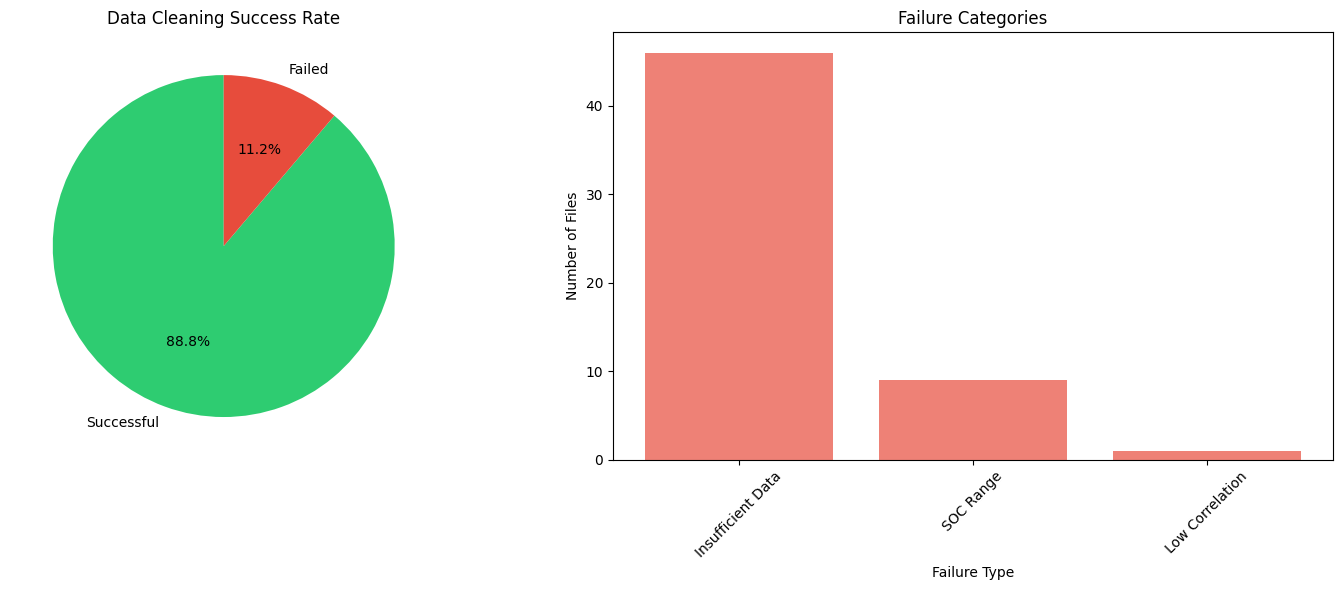

In [7]:
# Print processing statistics
stats = results['statistics']
print(f"\n=== DATA CLEANING RESULTS ===")
print(f"Total files processed: {stats['total_files']}")
print(f"Successful: {stats['successful_files']} ({stats['success_rate']:.1f}%)")
print(f"Failed: {stats['failed_files']} ({(stats['failed_files']/stats['total_files'])*100:.1f}%)")
print(f"Processing time: {stats['processing_time']:.1f} seconds")

# Analyze failure reasons
if results['failed_files']:
    print(f"\n=== FAILURE ANALYSIS ===")
    
    # Categorize failures
    failure_categories = {}
    for failure in results['failed_files']:
        error_msg = failure['error']
        # Extract main failure type
        if 'SOC range' in error_msg:
            category = 'SOC Range'
        elif 'correlation' in error_msg:
            category = 'Low Correlation'
        elif 'Non-monotonic' in error_msg:
            category = 'Non-monotonic Trend'
        elif 'Insufficient discharge' in error_msg:
            category = 'Insufficient Data'
        elif 'Missing required columns' in error_msg:
            category = 'Wrong Format'
        else:
            category = 'Other'
        
        failure_categories[category] = failure_categories.get(category, 0) + 1
    
    print("Failure categories:")
    for category, count in sorted(failure_categories.items()):
        print(f"  {category}: {count} files")

# Visualize success rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Success/Failure pie chart
labels = ['Successful', 'Failed']
sizes = [stats['successful_files'], stats['failed_files']]
colors = ['#2ecc71', '#e74c3c']

ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Data Cleaning Success Rate')

# Failure categories bar chart (if there are failures)
if results['failed_files']:
    categories = list(failure_categories.keys())
    counts = list(failure_categories.values())
    
    ax2.bar(categories, counts, color='#e74c3c', alpha=0.7)
    ax2.set_title('Failure Categories')
    ax2.set_xlabel('Failure Type')
    ax2.set_ylabel('Number of Files')
    ax2.tick_params(axis='x', rotation=45)
else:
    ax2.text(0.5, 0.5, 'No Failures!', ha='center', va='center', 
             transform=ax2.transAxes, fontsize=16, color='green')
    ax2.set_title('Failure Categories')

plt.tight_layout()
plt.show()

## Sample Data Quality Check


=== SAMPLE CLEANED DATA ===
File: 00001.csv
Battery ID: B0047
Data points: 469
SOC range: 0.149 to 1.000
Voltage range: 2.471V to 4.039V


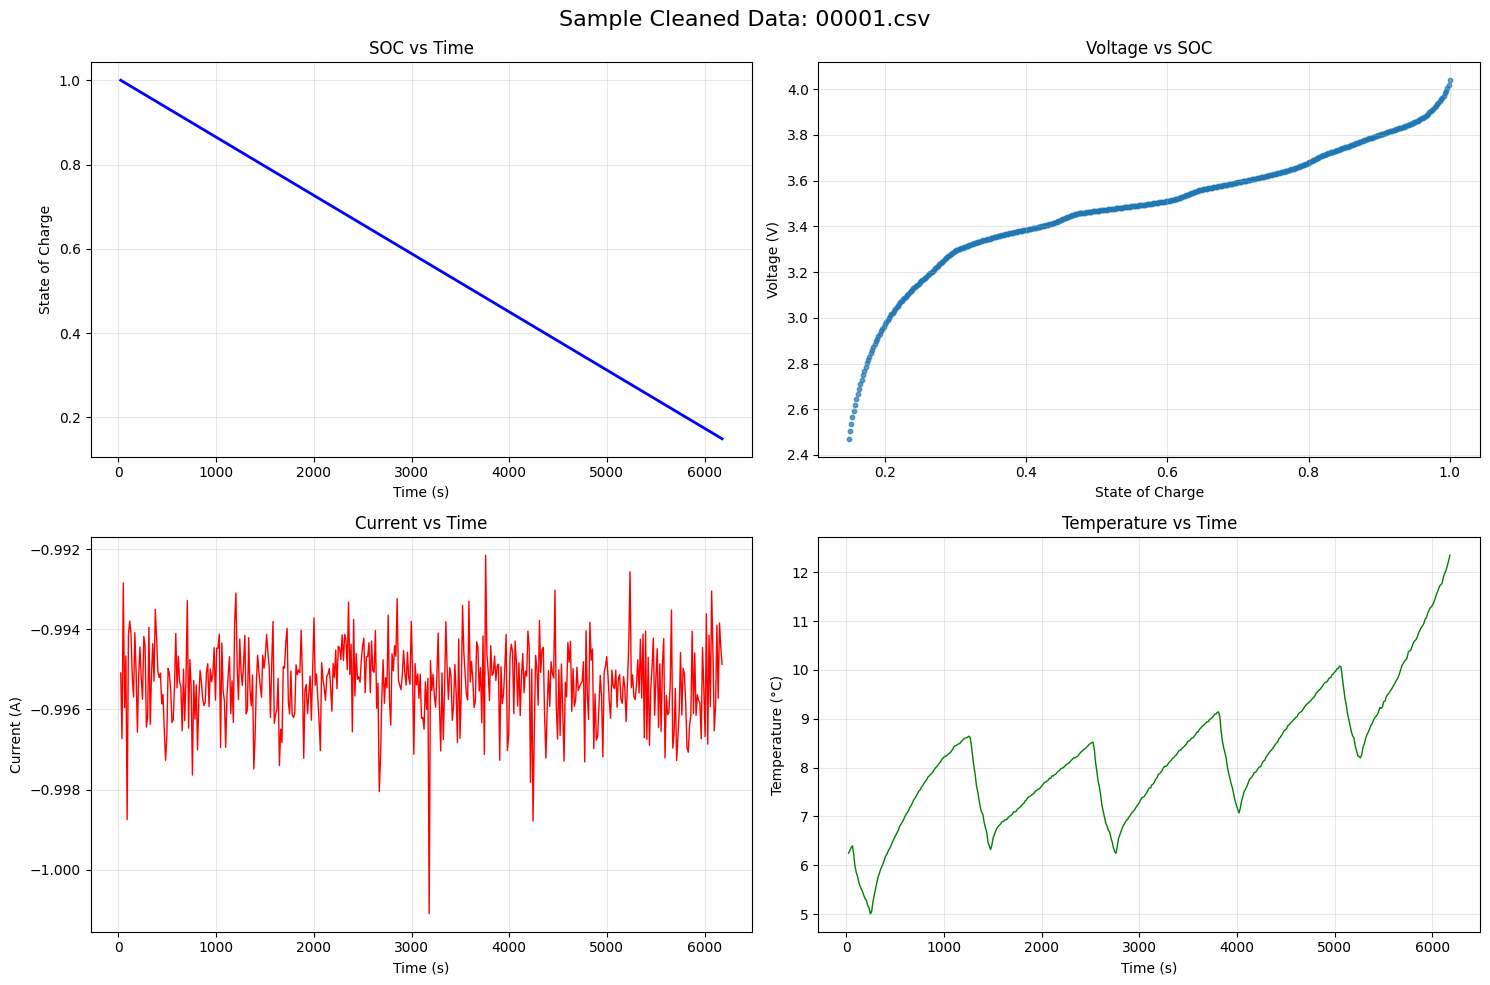


=== DATA CLEANING COMPLETE ===
High-quality discharge data is now ready for feature engineering and ML model training!


In [8]:
# Load and examine the cleaned data
if results['cleaned_data']:
    # Show sample from cleaned data
    sample_data = results['cleaned_data'][0]  # First successful file
    
    print(f"\n=== SAMPLE CLEANED DATA ===")
    print(f"File: {sample_data['filename'].iloc[0]}")
    print(f"Battery ID: {sample_data['battery_id'].iloc[0]}")
    print(f"Data points: {len(sample_data)}")
    print(f"SOC range: {sample_data['SOC'].min():.3f} to {sample_data['SOC'].max():.3f}")
    print(f"Voltage range: {sample_data['Voltage_measured'].min():.3f}V to {sample_data['Voltage_measured'].max():.3f}V")
    
    # Visualize sample data
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Sample Cleaned Data: {sample_data["filename"].iloc[0]}', fontsize=16)
    
    # SOC vs Time
    axes[0, 0].plot(sample_data['Time'], sample_data['SOC'], 'b-', linewidth=2)
    axes[0, 0].set_title('SOC vs Time')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('State of Charge')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Voltage vs SOC
    axes[0, 1].scatter(sample_data['SOC'], sample_data['Voltage_measured'], alpha=0.7, s=10)
    axes[0, 1].set_title('Voltage vs SOC')
    axes[0, 1].set_xlabel('State of Charge')
    axes[0, 1].set_ylabel('Voltage (V)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Current vs Time
    axes[1, 0].plot(sample_data['Time'], sample_data['Current_measured'], 'r-', linewidth=1)
    axes[1, 0].set_title('Current vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Current (A)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Temperature vs Time
    axes[1, 1].plot(sample_data['Time'], sample_data['Temperature_measured'], 'g-', linewidth=1)
    axes[1, 1].set_title('Temperature vs Time')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Temperature (°C)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n=== DATA CLEANING COMPLETE ===")
print(f"High-quality discharge data is now ready for feature engineering and ML model training!")

## Process All Remaining Files

In [10]:
# Uncomment to process all discharge files (this may take several minutes)
print("Processing ALL discharge files...")
full_results = clean_all_discharge_data(max_files=None, save_results=True)
 
print(f"\n=== FULL DATASET RESULTS ===")
full_stats = full_results['statistics']
print(f"Total discharge files: {full_stats['total_files']}")
print(f"Successfully cleaned: {full_stats['successful_files']} ({full_stats['success_rate']:.1f}%)")
print(f"Processing time: {full_stats['processing_time']:.1f} seconds")

Processing ALL discharge files...
Processing 2794 discharge files...


100%|██████████| 2794/2794 [00:03<00:00, 859.67it/s]



Saved 541510 data points to processed_data/cleaned_discharge_data.csv

=== FULL DATASET RESULTS ===
Total discharge files: 2794
Successfully cleaned: 2314 (82.8%)
Processing time: 3.3 seconds
